In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

from py_helper_functions import *

from datetime import datetime

from patsy.highlevel import dmatrices
from sklearn.metrics import brier_score_loss, roc_curve, auc, confusion_matrix, roc_auc_score, mean_squared_error
import sklearn.metrics as metrics

In [2]:
# helper functions
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def create_roc_plots(y_true, X_, models):
    all_model_predict_proba = dict()
    for m_name, model in models.items():
        fpr, tpr, thresholds = roc_curve(y_true, model.predict_proba(X_)[:,1])
        if 'fpr' in all_model_predict_proba.keys():
            all_model_predict_proba['fpr'] = all_model_predict_proba['fpr'] + fpr.tolist()
            all_model_predict_proba['tpr'] = all_model_predict_proba['tpr'] + tpr.tolist()
            all_model_predict_proba['thresholds'] = all_model_predict_proba['thresholds'] + thresholds.tolist()
            all_model_predict_proba['model'] = all_model_predict_proba['model'] + [m_name] * len(fpr)
        else:
            all_model_predict_proba['fpr'] = fpr.tolist()
            all_model_predict_proba['tpr'] = tpr.tolist()
            all_model_predict_proba['thresholds'] = thresholds.tolist()
            all_model_predict_proba['model'] = [m_name] * len(fpr)
        
    all_coords = pd.DataFrame({
        'fpr': all_model_predict_proba['fpr'],
        'tpr': all_model_predict_proba['tpr'],
        'thresholds': all_model_predict_proba['thresholds'],
        'model': all_model_predict_proba['model']
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr', color = 'model')) \
        + geom_line() \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

In [3]:
def get_sme_comp_default(df):
    '''
    This function determine the default status for SME firms
    :param df: raw data
    :return: dataframe with default status for only SME firms
    '''
    # add all missing year and comp_id combinations -
    # originally missing combinations will have NAs in all other columns
    df = (
        df.set_index(["year", "comp_id"])
        .unstack(fill_value="toReplace")
        .stack()
        .reset_index()
    )
    df = df.replace("toReplace", np.nan)  # only way I could define it as NaN
    
    # generate status_alive; if sales larger than zero and not-NA, then firm is alive
    df["status_alive"] = (df["sales"] > 0 & (False == df["sales"].isna())).astype(int)
    
    # defaults in one year if there are sales in this year but no sales one year later
    # Status_in_one_years: data.groupby('comp_id')['status_alive'].shift(-1)
    df["default"] = (
        (df["status_alive"] == 1)
        & (df.groupby("comp_id")["status_alive"].shift(-1) == 0)
    ).astype(int)
    
    # filter for SME firms
    return df[(df.sales >= 1000) & (df.sales <= 10_000_000)]

def label_engineering(data):
    # engineering new features
    data['n_day_alive'] = data.apply(lambda x: (pd.Timestamp(f'31/12/{x.year}') - pd.Timestamp(x['founded_date'])).days, axis=1)
    
    # Firm characteristics
    data["n_day_alive_sq"] = data["n_day_alive"] ** 2
    data["f_foreign_management"] = np.where(
        data["foreign"] >= 0.5, 'Yes', np.where(data["foreign"].isna(), 'Missing', 'No')
    )
    
    ###########################################################
    # look at more financial variables, create ratios
    ###########################################################
    
    # assets can't be negative. Change them to 0 and add a flag.
    data["flag_asset_problem"] = np.where(
        (
            (data["intang_assets"] < 0)
            | (data["curr_assets"] < 0)
            | (data["fixed_assets"] < 0)
        ),
        1,
        0,
    )
    data["flag_asset_problem"] = np.where(
        (
            (data["intang_assets"].isna())
            | (data["curr_assets"].isna())
            | (data["fixed_assets"].isna())
        ),
        1,
        data["flag_asset_problem"],
    )
    data["intang_assets"] = np.where((data["intang_assets"] < 0) | (data["intang_assets"].isna()), 0, data["intang_assets"])
    data["curr_assets"] = np.where((data["curr_assets"] < 0) | (data["curr_assets"].isna()), 0, data["curr_assets"])
    data["fixed_assets"] = np.where((data["fixed_assets"] < 0) | (data["fixed_assets"].isna()), 0, data["fixed_assets"])
    
    # generate total assets
    data["total_assets_bs"] = (
        data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
    )
    
    # handling pl and bs
    pl_names = [
        "extra_exp",
        "extra_inc",
        "extra_profit_loss",
        "inc_bef_tax",
        "inventories",
        "material_exp",
        "profit_loss_year",
        "personnel_exp",
    ]
    bs_names = [
        "intang_assets",
        "curr_liab",
        "fixed_assets",
        "liq_assets",
        "curr_assets",
        "share_eq",
        "subscribed_cap",
        "tang_assets",
    ]
    # divide all pl_names elements by sales and create new column for it
    data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
        data["sales"], axis="index"
    )
    # divide all bs_names elements by total_assets_bs and create new column for it
    data[[col + "_bs" for col in bs_names]] = (
        data[bs_names]
        .div(data["total_assets_bs"], axis="index")
        .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
    )
    # get 0 values where total_assets_bs is NaN
    for col in bs_names:
        data[col + "_bs"] = np.where(
            data["total_assets_bs"].isna(), 0, data[col + "_bs"]
        )
        
    ########################################################################
    # creating flags, and winsorizing tails
    ########################################################################
    
    # Variables that represent accounting items that cannot be negative (e.g. materials)
    zero = [
        "extra_exp_pl",
        "extra_inc_pl",
        "inventories_pl",
        "material_exp_pl",
        "personnel_exp_pl",
        "curr_liab_bs",
        "fixed_assets_bs",
        "liq_assets_bs",
        "curr_assets_bs",
        "subscribed_cap_bs",
        "intang_assets_bs",
    ]
    
    data[[col + "_flag_high" for col in zero]] = np.where(
        data[zero].isna(), 0, (data[zero] > 1).astype(int)
    )
    data[[col for col in zero]] = np.where(
        data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
    )
    data[[col + "_flag_error" for col in zero]] = np.where(
        data[zero].isna(), 1, (data[zero] < 0).astype(int)
    )
    data[[col for col in zero]] = np.where(
        data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
    )
    
    # for vars that could be any, but are mostly between -1 and 1
    anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]
    
    data[[col + "_flag_low" for col in anyof]] = np.where(
        data[anyof].isna(), 0, (data[anyof] < -1).astype(int)
    )
    data[[col for col in anyof]] = np.where(
        data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
    )
    data[[col + "_flag_high" for col in anyof]] = np.where(
        data[anyof].isna(), 0, (data[anyof] > 1).astype(int)
    )
    data[[col for col in anyof]] = np.where(
        data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
    )
    data[[col + "_flag_zero" for col in anyof]] = np.where(
        data[anyof].isna(), 0, (data[anyof] == 0).astype(int)
    )
    
    data[[col + "_flag_error" for col in anyof]] = np.where(
        data[anyof].isna(), 1, 0
    )
    
    data[["n_" + col + "_quad" for col in anyof]] = np.where(
        data[anyof].isna(), np.nan, data[anyof] ** 2
    )
    
    # dropping flags with no variation
    flag_columns = [col for col in data.columns if "flag" in col]
    data = data.drop(
        data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
    )
    
    # CEO age
    data["n_ceo_age"] = data["year"] - data["birth_year"]
    data = data.assign(
        flag_low_ceo_age=(data["n_ceo_age"] < 25).astype(int),
        flag_high_ceo_age=(data["n_ceo_age"] > 75).astype(int),
        flag_miss_ceo_age=(data["n_ceo_age"].isna()).astype(int),
    )
    data["n_ceo_age"] = np.where(data["n_ceo_age"] < 25, 25, data["n_ceo_age"])
    data["n_ceo_age"] = np.where(data["n_ceo_age"] > 75, 75, data["n_ceo_age"])
    data["n_ceo_age"] = np.where(
        data["n_ceo_age"].isna(), data["n_ceo_age"].mean(), data["n_ceo_age"]
    )
    data["d_ceo_young"] = (data["n_ceo_age"] < 40).astype(int)
    
    # log sales
    data['n_sales_mil_log'] = np.log(data["sales"] / 1000000)
    data['n_sales_mil_logsq'] = data["n_sales_mil_log"] ** 2
    
    # YoY growth 
    data['n_yoy_growth'] = data.sales / data.groupby(['comp_id'])['sales'].shift(1) - 1
    data['n_yoy_growth'] = data['n_yoy_growth'].fillna(0)
    
    # Gross Profit Margin
    data['n_gross_profit_margin'] = (data['sales'] - (data['material_exp'] + data['personnel_exp'])) / data['sales']
    
    # Net Profit Margin
    data['n_net_profit_margin'] = (data['profit_loss_year'] / data['sales']).replace((np.inf, -np.inf, np.nan), (0, 0, 0))
    
    # Return on Equity (ROE)
    data['n_return_on_equity'] = (data['profit_loss_year'] / data['share_eq']).replace((np.inf, -np.inf, np.nan), (0, 0, 0))
    
    # Debt-Equity Ratio
    # Note: we need to adjust 'curr_liab' to total liabilities if we have that information. Need to further investigate the data.
    data['n_debt_equity_ratio'] = (data['curr_liab'] / data['share_eq']).replace((np.inf, -np.inf, np.nan), (0, 0, 0))
    
    # Current Ratio
    data['n_current_ratio'] = (data['curr_assets'] / data['curr_liab']).replace((np.inf, -np.inf, np.nan), (0, 0, 0))
    
    # Quick Ratio
    data['n_quick_ratio'] = ((data['curr_assets'] - data['inventories']) / data['curr_liab']).replace((np.inf, -np.inf, np.nan), (0, 0, 0))
    
    # Return on Assets (ROA)
    data['n_return_on_assets'] = (data['profit_loss_year'] / data['total_assets_bs']).replace((np.inf, -np.inf, np.nan), (0, 0, 0))
    
    # rename columns
    data.rename(columns={'amort': 'n_amort',
                            # 'curr_assets': 'n_curr_assets',
                            # 'curr_liab': 'n_curr_liab',
                            # 'extra_exp': 'n_extra_exp',
                            # 'extra_inc': 'n_extra_inc',
                            # 'extra_profit_loss': 'n_extra_profit_loss',
                            # 'fixed_assets': 'n_fixed_assets',
                            # 'inc_bef_tax': 'n_inc_bef_tax',
                            # 'intang_assets': 'n_intang_assets',
                            # 'inventories': 'n_inventories',
                            # 'liq_assets': 'n_liq_assets',
                            # 'material_exp': 'n_material_exp',
                            # 'personnel_exp': 'n_personnel_exp',
                            # 'profit_loss_year': 'n_profit_loss_year',
                            # 'sales': 'n_sales',
                            # 'share_eq': 'n_share_eq',
                            # 'subscribed_cap': 'n_subscribed_cap',
                            # 'tang_assets': 'n_tang_assets',
                            'balsheet_flag': 'd_balsheet_flag',
                            'balsheet_length': 'n_balsheet_length',
                            'balsheet_notfullyear': 'd_balsheet_notfullyear',
                            'ceo_count': 'n_ceo_count',
                            # 'foreign': 'n_foreign',
                            'female': 'n_female',
                            'inoffice_days': 'n_inoffice_days',
                            'gender': 'f_gender',
                            'origin': 'f_origin',
                            'urban_m': 'f_urban_m',
                            'region_m': 'f_region_m',
                            'day_alive': 'n_day_alive'}, inplace=True)
    
    return data

def get_cleaned_data(local=True):
    '''
    This function reads from csv files, cleans it and returns the cleaned dataframe
    :param local: default True
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    
    if local:
        raw_files = ['cs_bisnode_panel1.csv', 'cs_bisnode_panel2.csv']
    else:
        raw_files = ['https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment3/cs_bisnode_panel1.csv', 'https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment3/cs_bisnode_panel2.csv']
        
    dfs = []
    for file in raw_files:
        u_df = pd.read_csv(file)
        dfs.append(u_df)
    df = pd.concat(dfs, ignore_index=True)
    
    # drop variables with many NAs
    df = df.drop(columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages", "D", "exit_year", "exit_date", "labor_avg", "founded_year"])

    filtered_sample = get_sme_comp_default(df[(df.ind2 == 26)])
    
    # label engineering
    working_sample = label_engineering(filtered_sample)
    
    # create the list of categorical and numerical column names
    categorical_columns = [col for col in working_sample.columns if col.startswith("f_")]
    # numerical_columns = [col for col in working_sample.columns if col.startswith("n_")]
    numerical_columns = [col for col in working_sample.columns if col.startswith("n_") or (("_pl" in col or "_bs" in col) and "flag" not in col)]
    # binary_columns = [col for col in working_sample.columns if col.startswith("d_")]
    binary_columns = [col for col in working_sample.columns if col.startswith("d_") or ('flag' in col and col != 'imputed_flag')]
    
    # flag observations with missing values to impute
    working_sample['imputed_flag'] = working_sample[categorical_columns + numerical_columns].isna().any(axis=1)

    # handle missing values for categorical features
    working_sample[categorical_columns] = working_sample[categorical_columns].fillna('Missing')

    # handle missing values for numerical features by replacing with median as distribution is not symmetrical
    num_medians = working_sample[numerical_columns].mean()
    working_sample[numerical_columns] = working_sample[numerical_columns].fillna(num_medians)
    
    del df
        
    return working_sample[(working_sample["begin"].notna()) & (working_sample.year < 2016)], categorical_columns, numerical_columns + binary_columns

In [4]:
work_df, categorical_columns, numerical_columns = get_cleaned_data()
# work_df = get_cleaned_data(local=False)
work_df.head(20)

,year,comp_id,begin,end,n_amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,n_sales_mil_logsq,n_yoy_growth,n_gross_profit_margin,n_net_profit_margin,n_return_on_equity,n_debt_equity_ratio,n_current_ratio,n_quick_ratio,n_return_on_assets,imputed_flag
0,2005,6538183.0,01/01/2005,31/12/2005,792.592590,6237.037109,348.148163,0.000000,0.000000,0.000000,...,12.464763,0.0,-0.007714,-0.039074,-0.152217,0.046305,17.914893,17.914893,-0.144123,False
1,2005,6934257.0,13/05/2005,31/12/2005,803.703674,4648.147949,9311.111328,0.000000,0.000000,0.000000,...,31.454961,0.0,-1.651515,-1.958586,-12.509677,16.219355,0.499204,0.499204,-0.434559,True
2,2005,8416055.0,01/01/2005,31/12/2005,3155.555664,71070.367190,25514.814450,74.074074,0.000000,-74.074074,...,2.985813,0.0,0.123340,0.000000,0.000000,0.433761,2.785455,2.632893,0.000000,False
5,2005,12428378.0,01/01/2005,31/12/2005,3137.037109,1740.740723,2192.592529,0.000000,0.000000,0.000000,...,12.291621,0.0,0.144109,0.016780,0.345178,1.502538,0.793919,0.793919,0.137374,False
7,2005,15711554.0,01/01/2005,31/12/2005,1592.592651,4740.740723,4970.370605,0.000000,7407.407227,7407.407227,...,22.081296,0.0,-0.595199,0.035395,0.428571,6.610838,0.953800,0.822653,0.056311,False
8,2005,16005183.0,01/01/2005,31/12/2005,5659.259277,71714.812500,40607.406250,0.000000,0.000000,0.000000,...,2.241016,0.0,0.096415,-0.018932,-0.094702,0.907616,1.766053,0.771616,-0.049577,False
10,2005,17776540.0,01/01/2005,31/12/2005,11722.222660,167988.890600,156914.812500,0.000000,1851.851807,1851.851807,...,0.071402,0.0,0.064721,0.014524,0.131661,1.858120,1.070574,0.689971,0.036592,True
15,2005,50481104.0,01/01/2005,31/12/2005,288.888886,814.814819,2411.111084,0.000000,0.000000,0.000000,...,19.269994,0.0,0.040908,-0.022096,0.564885,-4.969466,0.337942,0.337942,-0.142308,False
16,2005,55608576.0,01/01/2005,31/12/2005,3196.296387,3781.481445,0.000000,0.000000,0.000000,0.000000,...,27.539038,0.0,0.812676,0.126761,0.118655,0.000000,0.000000,0.000000,0.097826,False
22,2005,82197808.0,01/01/2005,31/12/2005,20574.074220,151692.593800,156037.031300,0.000000,0.000000,0.000000,...,0.414887,0.0,0.006531,0.010537,0.209420,5.905523,0.972158,0.810420,0.019687,False


In [5]:
work_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11764 entries, 0 to 20118
Data columns (total 110 columns):
 #    Column                           Non-Null Count  Dtype  
---   ------                           --------------  -----  
 0    year                             11764 non-null  int64  
 1    comp_id                          11764 non-null  float64
 2    begin                            11764 non-null  object 
 3    end                              11764 non-null  object 
 4    n_amort                          11764 non-null  float64
 5    curr_assets                      11764 non-null  float64
 6    curr_liab                        11762 non-null  float64
 7    extra_exp                        11722 non-null  float64
 8    extra_inc                        11722 non-null  float64
 9    extra_profit_loss                11764 non-null  float64
 10   fixed_assets                     11764 non-null  float64
 11   inc_bef_tax                      11764 non-null  float64
 12   intang_

In [6]:
holdout_set = work_df[(work_df.year == 2014)]
holdout_set.shape

(1037, 110)

In [7]:
holdout_set.default.sum()

56

In [8]:
training_set = work_df[(work_df.year != 2014)]
training_set.shape

(10727, 110)

In [9]:
len(categorical_columns + numerical_columns)

80

In [10]:
training_set[numerical_columns].skew();

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns)
    ], remainder='passthrough'
)

Logit

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

def get_logit_pipe(scoring='roc_auc'):
    # no regularisation needed so setting the parameter to very high value
    Cs_value_logit = [1e20]
    
    # define cv search
    logit_search = LogisticRegressionCV(
        Cs=Cs_value_logit,
        refit=True, 
        scoring=scoring, 
        solver="liblinear", 
        tol=1e-7, 
        random_state=42
    )

    logit_pipe = Pipeline(
        [("preprocess", preprocessing), ("regressor", logit_search)], verbose=True
    )
    
    return logit_pipe, logit_search

logit_pipe, logit_search = get_logit_pipe()

In [13]:
start_time = datetime.now()
logit_results = logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
logit_time = datetime.now() - start_time

scores = logit_search.scores_[1]  # For class label 1
mean_scores = np.mean(scores, axis=0)
mean_scores

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.3s


array([0.62874523])

In [14]:
logit_holdout_rmse = mean_squared_error(logit_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
logit_holdout_rmse

0.29529391629014884

LASSO Logit

In [15]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# define cv search
# lasso_search = GridSearchCV(
#     lasso_model,
#     {"alpha":[i/100 for i in range(1, 5, 1)], "l1_ratio": [0.1, 0.2, 0.3],},
#     cv=5,
#     scoring="neg_root_mean_squared_error",
#     verbose=3,
# )

def get_lasso_logit_pipe(scoring='roc_auc'):
    lambdas = list(10**np.arange(-1, -4.01, -1/3))
    n_obs = training_set.shape[0]*4/5
    Cs_values = [1/(l*n_obs) for l in lambdas]
    
    lasso_search = LogisticRegressionCV(
        Cs = Cs_values, 
        penalty = 'l1', # L1 makes it lasso
        cv = 5, 
        refit = True, 
        scoring = scoring, 
        solver = 'liblinear',
        random_state = 42
    )
    
    lasso_pipe = Pipeline(
        [("preprocess", preprocessing), 
         ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
         ('scaling', StandardScaler()),
         ("regressor", lasso_search)
         ], verbose=True
    )
    
    return lasso_pipe, lasso_search

lasso_pipe, lasso_search = get_lasso_logit_pipe()

In [16]:
start_time = datetime.now()
lasso_results = lasso_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
lasso3_time = datetime.now() - start_time
lasso_results

[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing interactions, total=   0.2s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.3s
[Pipeline] ......... (step 4 of 4) Processing regressor, total=11.7min


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_gender', 'f_origin',
                                                   'f_urban_m', 'f_region_m',
                                                   'f_foreign_management'])])),
                ('interactions',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('scaling', StandardScaler()),
                ('regressor',
                 LogisticRegressionCV(Cs=[0.001165283863149063,
                                          0.0025105279785027075,
                                          0.0054087685671818505,
                                          0.011652838631490626,
                                          0.025105279785027055,
                                          0.054087685671818445,
                                          0.11652838631490617,
                                          0.25105279785027057,
                                          0.5408768567181845,
                                          1.1652838631490607],
                                      cv=5, penalty='l1', random_state=42,
                                      scoring='roc_auc', solver='liblinear'))],
         verbose=True)

In [17]:
# Getting the best score and corresponding C for binary classification
scores = lasso_search.scores_[1]  # For class label 1
mean_scores = np.mean(scores, axis=0)
best_score = np.max(mean_scores)
best_C_index = np.argmax(mean_scores)
best_C = lasso_search.Cs_[best_C_index]

print(f"Best Score: {best_score}, Best C: {best_C}")

Best Score: 0.7792534585017507, Best C: 0.025105279785027055


In [18]:
lasso_holdout_rmse = mean_squared_error(lasso_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
lasso_holdout_rmse

0.24862985937178697

Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

grid = {'max_features': [15, 18, 20, 24],
        'criterion':['gini'],
        'min_samples_split': [10, 15, 20],
        "min_samples_leaf": [5, 10, 15]}

prob_forest = RandomForestClassifier(
    random_state=42, 
    n_estimators=500, 
    oob_score=True)

prob_forest_search = GridSearchCV(
    prob_forest, 
    grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc', 'neg_brier_score', 'accuracy'], 
    n_jobs=-1)

prob_forest_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", prob_forest_search)], verbose=True
)

In [61]:
start_time = datetime.now()
prob_forest_results = prob_forest_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
prob_forest1_time = datetime.now() - start_time
prob_forest_results

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=11.3min


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_gender', 'f_origin',
                                                   'f_urban_m', 'f_region_m',
                                                   'f_foreign_management'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(n_estimators=500,
                                                               oob_score=True,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'criterion': ['gini'],
                                          'max_features': [7, 15, 18, 20, 24],
                                          'min_samples_leaf': [5, 10, 15],
                                          'min_samples_split': [10, 15, 20]},
                              refit='roc_auc',
                              scoring=['roc_auc', 'neg_brier_score',
                                       'accuracy']))],
         verbose=True)

In [62]:
prob_forest_search.best_params_

{'criterion': 'gini',
 'max_features': 20,
 'min_samples_leaf': 10,
 'min_samples_split': 10}

In [63]:
prob_forest_search.best_score_

0.796296301575353

In [23]:
df_rf_model_cv_results = pd.DataFrame(prob_forest_search.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 
    'param_min_samples_split', 'rank_test_roc_auc', 'mean_test_roc_auc']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'min split size', 'rank roc auc', 'roc auc score']
# df_rf_model_cv_results.pivot(
#     index = 'max features', 
#     columns = 'min node size', 
#     values = 'RMSE').round(2)*-1
df_rf_model_cv_results;

In [24]:
prob_rf_holdout_rmse = mean_squared_error(prob_forest_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
prob_rf_holdout_rmse

0.25299291703562604

GBM

In [51]:
from sklearn.ensemble import HistGradientBoostingClassifier

# gbm_grid = {"max_depth": [5, 10, 15], "min_samples_leaf": [5, 10, 15], "max_features": [8, 10, 12]}
gbm_grid = {"max_depth": [8, 10, 12, 15], "min_samples_leaf": [7, 8, 10], 'learning_rate': [0.1, 0.01]}

gbm = HistGradientBoostingClassifier( 
    random_state = 42)

gbm_search = GridSearchCV(
    gbm, 
    gbm_grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc', 'neg_brier_score', 'accuracy'], 
    n_jobs=-1)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_search)], verbose=True
)

In [52]:
start_time = datetime.now()
gbm_results = gbm_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)
gbm1_time = datetime.now() - start_time
gbm_results

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  20.3s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_gender', 'f_origin',
                                                   'f_urban_m', 'f_region_m',
                                                   'f_foreign_management'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=HistGradientBoostingClassifier(random_state=42),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.1, 0.01],
                                          'max_depth': [8, 10, 12, 15],
                                          'min_samples_leaf': [7, 8, 10]},
                              refit='roc_auc',
                              scoring=['roc_auc', 'neg_brier_score',
                                       'accuracy']))],
         verbose=True)

In [53]:
gbm_search.best_params_

{'learning_rate': 0.1, 'max_depth': 12, 'min_samples_leaf': 8}

In [29]:
gbm_search.best_score_

0.7781219228987295

In [30]:
gbm_holdout_rmse = mean_squared_error(gbm_pipe.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1], holdout_set['default'], squared=False)
gbm_holdout_rmse

0.295493541273484

In [31]:
df_gbm_model_cv_results = pd.DataFrame(gbm_search.cv_results_)[[
    'param_learning_rate', 'param_min_samples_leaf', 'param_max_depth', 'mean_fit_time', 'mean_test_roc_auc', 'rank_test_roc_auc']]
df_gbm_model_cv_results.columns = ['learning rate', 'min node size', 'max depth', 'fit time', 'ROC AUC', 'rank']
df_gbm_model_cv_results

,learning rate,min node size,max depth,fit time,ROC AUC,rank
0,0.1,5,12,1.217740,0.772692,4
1,0.1,7,12,1.116908,0.772592,5
2,0.1,8,12,1.021436,0.778122,1
3,0.1,5,15,1.073465,0.770292,12
4,0.1,7,15,1.017902,0.766188,18
5,0.1,8,15,1.024424,0.772918,3
6,0.1,5,18,1.043332,0.769965,14
7,0.1,7,18,1.026387,0.767700,17
8,0.1,8,18,1.042525,0.772975,2
9,0.01,5,12,1.188476,0.770087,13


In [32]:
# best estimator on holdout set
diag_df = pd.DataFrame({'Model': ['Logit', 'LASSO Logit', 'RF', 'GBM'],
                        'Holdout RMSE': [logit_holdout_rmse, lasso_holdout_rmse, prob_rf_holdout_rmse, gbm_holdout_rmse],
                        'Training time': [logit_time, lasso3_time, prob_forest1_time, gbm1_time]})
diag_df

,Model,Holdout RMSE,Training time
0,Logit,0.295294,0 days 00:00:02.344072
1,LASSO Logit,0.248630,0 days 00:11:43.769029
2,RF,0.252993,0 days 00:02:51.155469
3,GBM,0.295494,0 days 00:00:14.515166


Loss fnc

In [33]:
models = {'logit': logit_pipe,
          'lasso_logit': lasso_pipe,
          'rf': prob_forest_pipe,
          'gbm': gbm_pipe}

In [34]:
thresholds = [i/100 for i in range(5,80,5)]
models_cm = dict()
for m_name, model in models.items():
    cm = dict()
    true_positive_rates = []
    false_positive_rates = []
    holdout_prediction = []
    for thr in thresholds:
        holdout_prediction = np.where(model.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1] < thr, 0, 1)
        cm_thr = confusion_matrix(holdout_set.default, holdout_prediction, labels=[0,1])
        cm[thr] = cm_thr
        tn, fp, fn, tp = cm_thr.ravel()
        true_positive_rates.append(tp/(tp+fn))
        false_positive_rates.append(fp/(fp+tn))
    models_cm[m_name] = cm
models_cm;

In [35]:
# roc for each model
models_roc = dict()
for m_name, model in models.items():
    models_roc[m_name] = create_roc_plot(holdout_set.default, model.predict_proba(holdout_set[categorical_columns + numerical_columns])[:,1]);

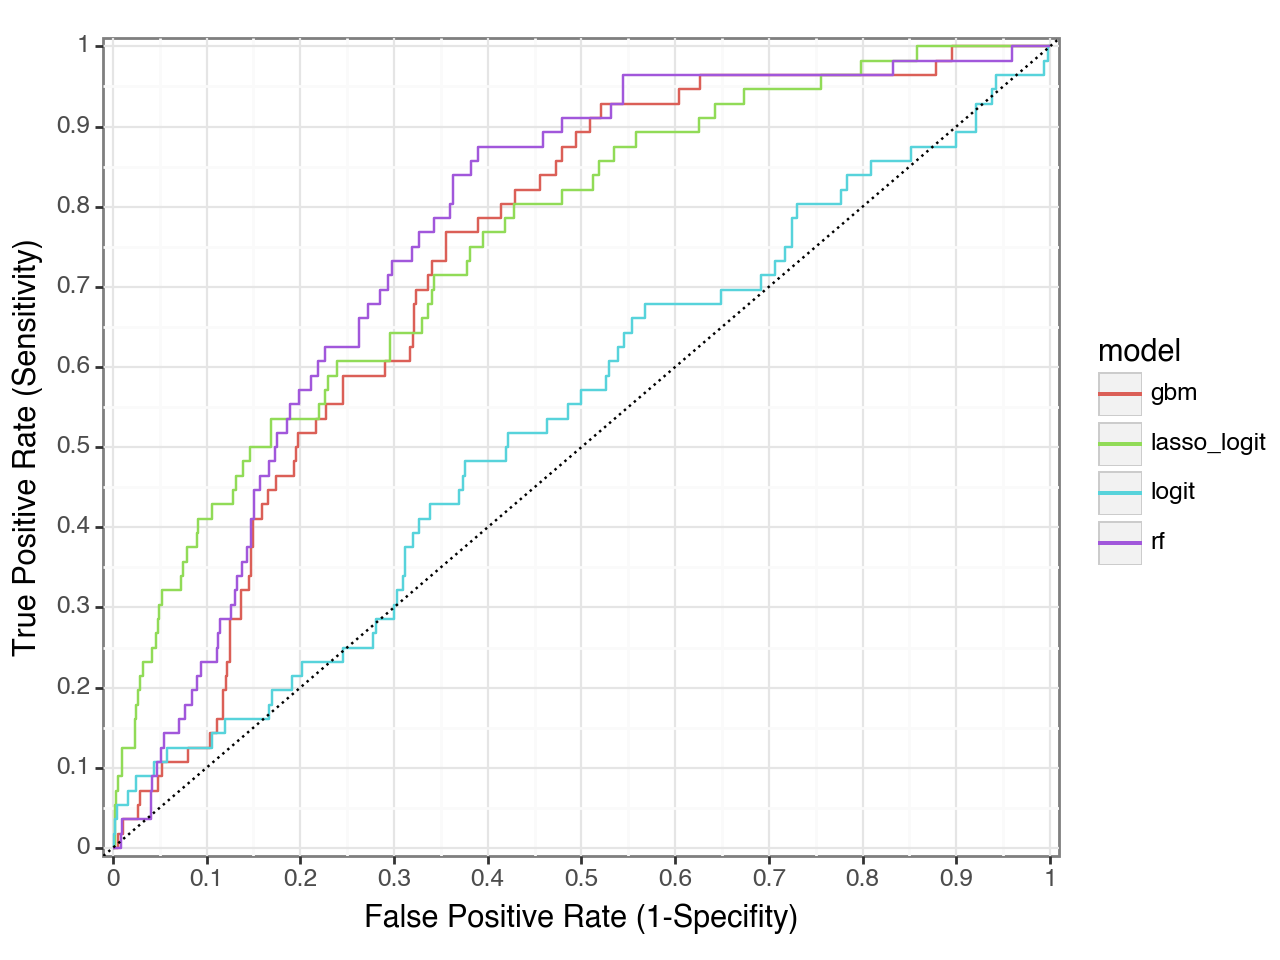

<Figure Size: (640 x 480)>

In [36]:
create_roc_plots(holdout_set.default, holdout_set[categorical_columns + numerical_columns], models)

Loss function

In [37]:
FP = 3
FN = 15
cost = FN/FP

# the prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))
prevelance = training_set.default.sum()/len(training_set.default)
prevelance

0.10133308473944252

In [38]:
# rmse
CV_RMSE_folds = dict()

# logit with brier score
brier_logit_pipe, brier_logit_search = get_logit_pipe(scoring='neg_brier_score')
brier_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

CV_RMSE_folds['logit'] = np.sqrt(-1 * brier_logit_search.scores_[1].ravel())

# lasso logit with breier score
brier_lasso_logit_pipe, brier_lasso_logit_search = get_lasso_logit_pipe(scoring='neg_brier_score')
brier_lasso_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

lambdas = list(10**np.arange(-1, -4.01, -1/3))
n_obs = training_set.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]
lasso_best_lambda = cv_summary(lambdas=lambdas, C_values=Cs_values, model=brier_lasso_logit_search).sort_values('mean_cv_score', ascending = False).iloc[0,0]
for i, l in enumerate(lambdas):
    if l == lasso_best_lambda:
        best_lambda_i = i
        CV_RMSE_folds['lasso_logit'] = np.sqrt(-1*(brier_lasso_logit_search.scores_[1][:,i])).tolist()

# RF with brier score
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_search.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)

# GBM with brier score
CV_RMSE_folds["GBM"] = np.sqrt(
    pd.DataFrame(gbm_search.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)

pd.DataFrame(CV_RMSE_folds)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.5s
[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing interactions, total=   0.2s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.3s
[Pipeline] ......... (step 4 of 4) Processing regressor, total=11.5min


,logit,lasso_logit,RF,GBM
0,0.296541,0.294619,0.290559,0.293709
1,0.294216,0.282774,0.277122,0.284582
2,0.293351,0.283395,0.284296,0.290054
3,0.363772,0.292409,0.285958,0.279072
4,0.309281,0.284247,0.278697,0.271923


In [39]:
cv_summary(lambdas=lambdas, C_values=Cs_values, model=lasso_search).sort_values('mean_cv_score', ascending = False).iloc[0,1]

0.025105279785027055

In [40]:
lasso_best_lambda

0.004641588833612782

In [41]:
CV_AUC_folds = dict()

# logit with brier score
auc_logit_pipe, auc_logit_search = get_logit_pipe()
auc_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

CV_AUC_folds['logit'] = auc_logit_search.scores_[1].ravel()

# lasso logit with breier score
auc_lasso_logit_pipe, auc_lasso_logit_search = get_lasso_logit_pipe()
auc_lasso_logit_pipe.fit(training_set[categorical_columns + numerical_columns], training_set.default)

lambdas = list(10**np.arange(-1, -4.01, -1/3))
n_obs = training_set.shape[0]*4/5
Cs_values = [1/(l*n_obs) for l in lambdas]
lasso_best_lambda = cv_summary(lambdas=lambdas, C_values=Cs_values, model=auc_lasso_logit_search).sort_values('mean_cv_score', ascending = False).iloc[0,0]
for i, l in enumerate(lambdas):
    if l == lasso_best_lambda:
        best_lambda_i = i
        CV_AUC_folds['lasso_logit'] = (auc_lasso_logit_search.scores_[1][:,i]).tolist()

# RF with brier score
CV_AUC_folds["RF"] = pd.DataFrame(prob_forest_search.cv_results_).filter(like="_test_roc_auc").loc[lambda x: x["rank_test_roc_auc"] == 1].filter(like="split").values[0]

# GBM with brier score
CV_AUC_folds["GBM"] = pd.DataFrame(gbm_search.cv_results_).filter(like="_test_roc_auc").loc[lambda x: x["rank_test_roc_auc"] == 1].filter(like="split").values[0]

pd.DataFrame(CV_AUC_folds)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.8s
[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing interactions, total=   0.2s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.2s
[Pipeline] ......... (step 4 of 4) Processing regressor, total=11.5min


,logit,lasso_logit,RF,GBM
0,0.670519,0.715061,0.742979,0.717159
1,0.696919,0.800642,0.835003,0.826571
2,0.716934,0.806860,0.789161,0.680008
3,0.464436,0.763485,0.782930,0.817277
4,0.594917,0.810219,0.824129,0.849595


In [42]:
# cross validation method
k = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [43]:
from sklearn.linear_model import LogisticRegression

# Find optimal threshold
model_searches = {'logit': logit_search,
          'lasso_logit': lasso_search,
          'rf': prob_forest_search,
          'gbm': gbm_search}

best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

lasso_best_C = cv_summary(lambdas=lambdas, C_values=Cs_values, model=lasso_search).sort_values('mean_cv_score', ascending = False).iloc[0,1]

for model_name, model_search in model_searches.items():
    best_thresholds = list()
    expected_loss = list()
    fold = 0
    for train_index, test_index in k.split(training_set[categorical_columns + numerical_columns]):
        X_fold = training_set[categorical_columns + numerical_columns].iloc[test_index,:]
        y_fold = training_set.default.iloc[test_index]
        
        X_fold_train = training_set[categorical_columns + numerical_columns].iloc[train_index,:]
        y_fold_train = training_set.default.iloc[train_index]
        
        if model_name =='logit':
            model_best, _ = get_logit_pipe()
        elif model_name =='lasso_logit':
            best_lasso_model = LogisticRegression(
                C = lasso_best_C, 
                penalty = 'l1', # L1 makes it lasso
                solver = 'liblinear',
                random_state = 42
            )
            
            model_best = Pipeline(
                [("preprocess", preprocessing), 
                 ('interactions', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                 ('scaling', StandardScaler()),
                 ("regressor", best_lasso_model)
                 ], verbose=True
            )
        elif model_name == 'rf':
            best_prob_forest_model = RandomForestClassifier(
                random_state=42, 
                n_estimators=500, 
                oob_score=True,
                criterion = 'gini', 
                max_features = prob_forest_search.best_params_['max_features'], 
                min_samples_split = prob_forest_search.best_params_['min_samples_split'],
                min_samples_leaf = prob_forest_search.best_params_['min_samples_leaf'])
            
            model_best = Pipeline(
                [("preprocess", preprocessing), ("regressor", best_prob_forest_model)], verbose=True
            )
        else:
            best_gbm_model = HistGradientBoostingClassifier(
                random_state=42, 
                max_depth = gbm_search.best_params_['max_depth'], 
                learning_rate = gbm_search.best_params_['learning_rate'],
                min_samples_leaf = gbm_search.best_params_['min_samples_leaf'])
            
            model_best = Pipeline(
                [("preprocess", preprocessing), ("regressor", best_gbm_model)], verbose=True
            )
        
        best_model_fold = model_best.fit(X_fold_train, y_fold_train)
        pred_fold = best_model_fold.predict_proba(X_fold)[:,1]
    
        false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
        
        best_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate + (1 - prevelance)/(cost * prevelance)*(1-false_pos_rate)
                    ),
                    threshold
                )
            ), 
            key=lambda x: x[0], reverse=True)[0][1]
        
        best_thresholds.append(best_threshold)
        
        threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(y_fold, threshold_prediction, labels=[0,1]).ravel()
        curr_exp_loss = (fp*FP + fn*FN)/len(y_fold)
        expected_loss.append(curr_exp_loss)
        
    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)
        
    fold5_threshold[model_name] = best_threshold
    fold5_expected_loss[model_name] = curr_exp_loss
    
    all_coords = pd.DataFrame({
        'false_pos': false_pos_rate*sum(y_fold == 0),
        'true_pos': true_pos_rate*sum(y_fold == 1),
        'false_neg': sum(y_fold == 1) - true_pos_rate*sum(y_fold == 1),
        'true_neg': sum(y_fold == 0) - false_pos_rate*sum(y_fold == 0),
        'pos': sum(y_fold == 1),
        'neg': sum(y_fold == 0),
        'n': len(y_fold),
        'thresholds': threshold
    })
    
    fold5_all_coords[model_name] = all_coords
    
summary = pd.DataFrame(best_thresholds_cv.items(),columns=['Model', 'Avg of optimal thresholds'])
summary['Threshold for Fold5'] = fold5_threshold.values()
summary['Avg expected loss'] = expected_loss_cv.values()
summary['Expected loss for Fold5'] = fold5_expected_loss.values()
summary

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.4s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.7s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.2s
[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   1.5s
[Pipeline] ........ (step 1 of 4) Processing preprocess, total=   0.0s
[Pipeline] ...... (step 2 of 4) Processing interactions, total=   0.2s
[Pipeline] ........... (step 3 of 4) Processing scaling, total=   0.2s
[Pipeline] ......... (step 4 of 4) Processing regressor, total=   1.9s
[Pipel

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,logit,0.317973,0.170825,1.339055,1.180420
1,lasso_logit,0.155971,0.174990,1.076157,0.991608
2,rf,0.181282,0.186863,1.009877,0.934266
3,gbm,0.129441,0.111176,0.995054,0.979021


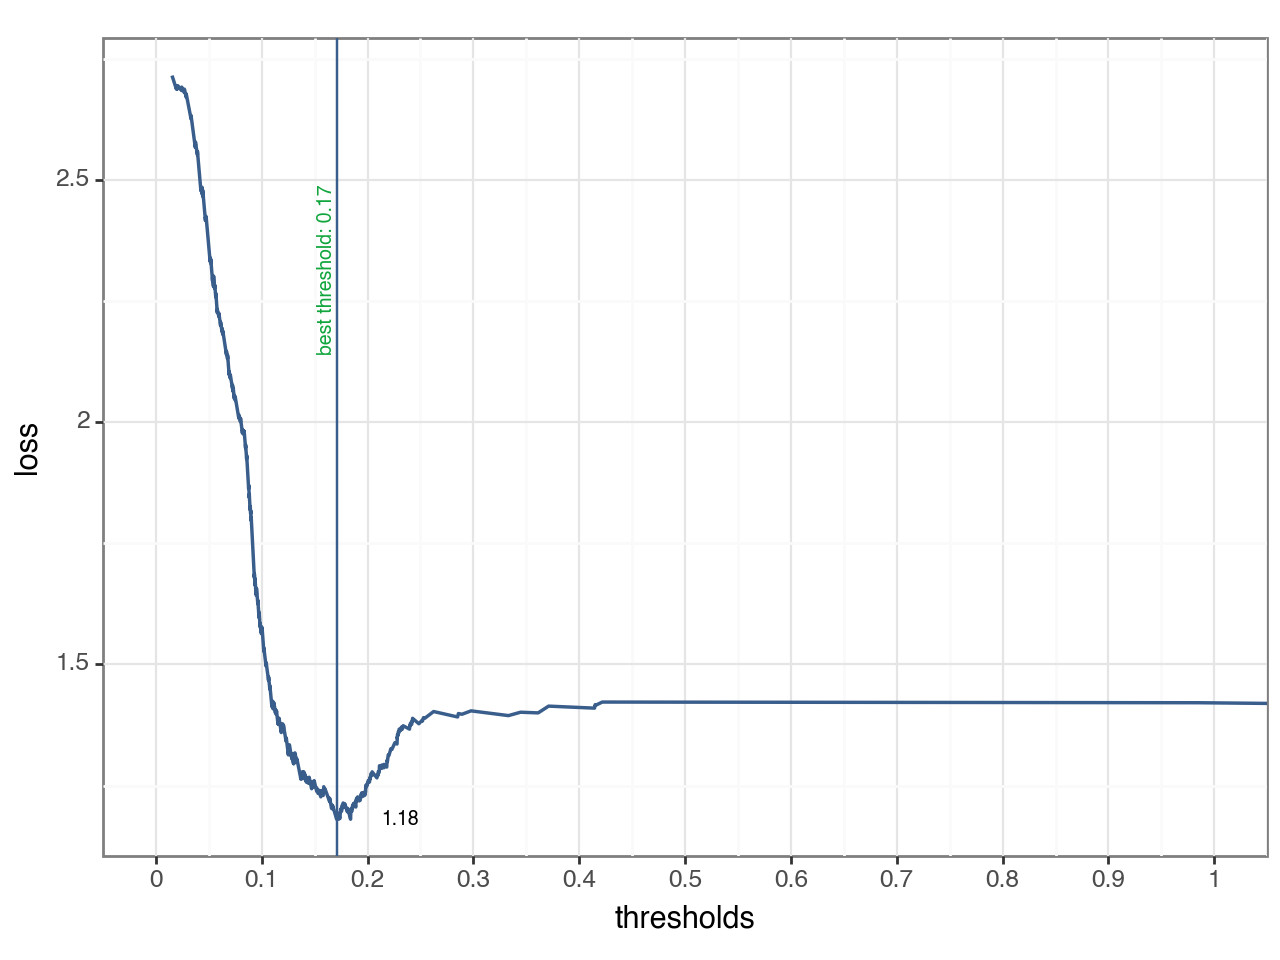

<Figure Size: (640 x 480)>

In [44]:
create_loss_plot(fold5_all_coords['logit'], fold5_threshold['logit'], fold5_expected_loss['logit'])

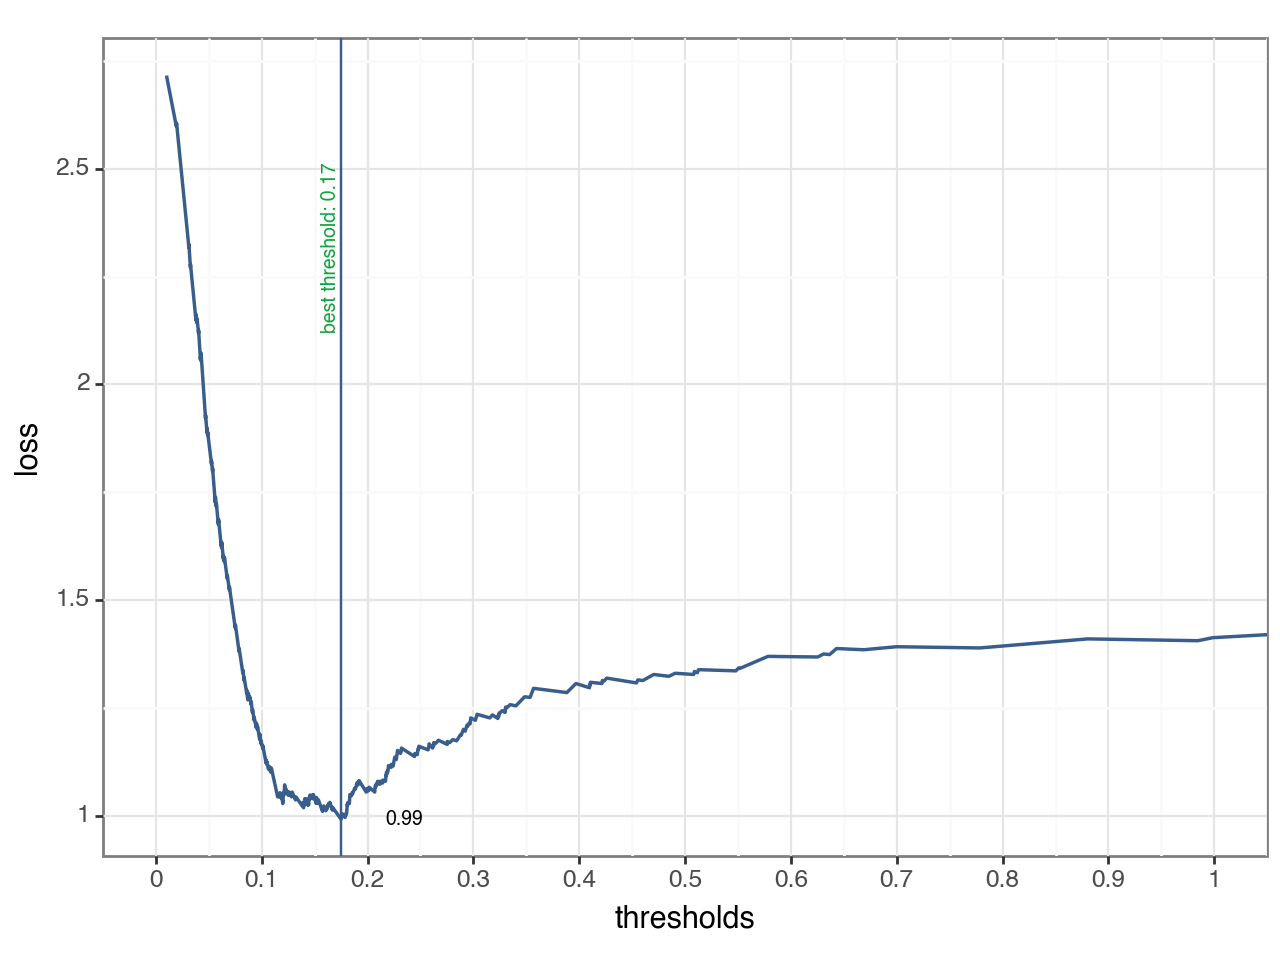

<Figure Size: (640 x 480)>

In [45]:
create_loss_plot(fold5_all_coords['lasso_logit'], fold5_threshold['lasso_logit'], fold5_expected_loss['lasso_logit'])

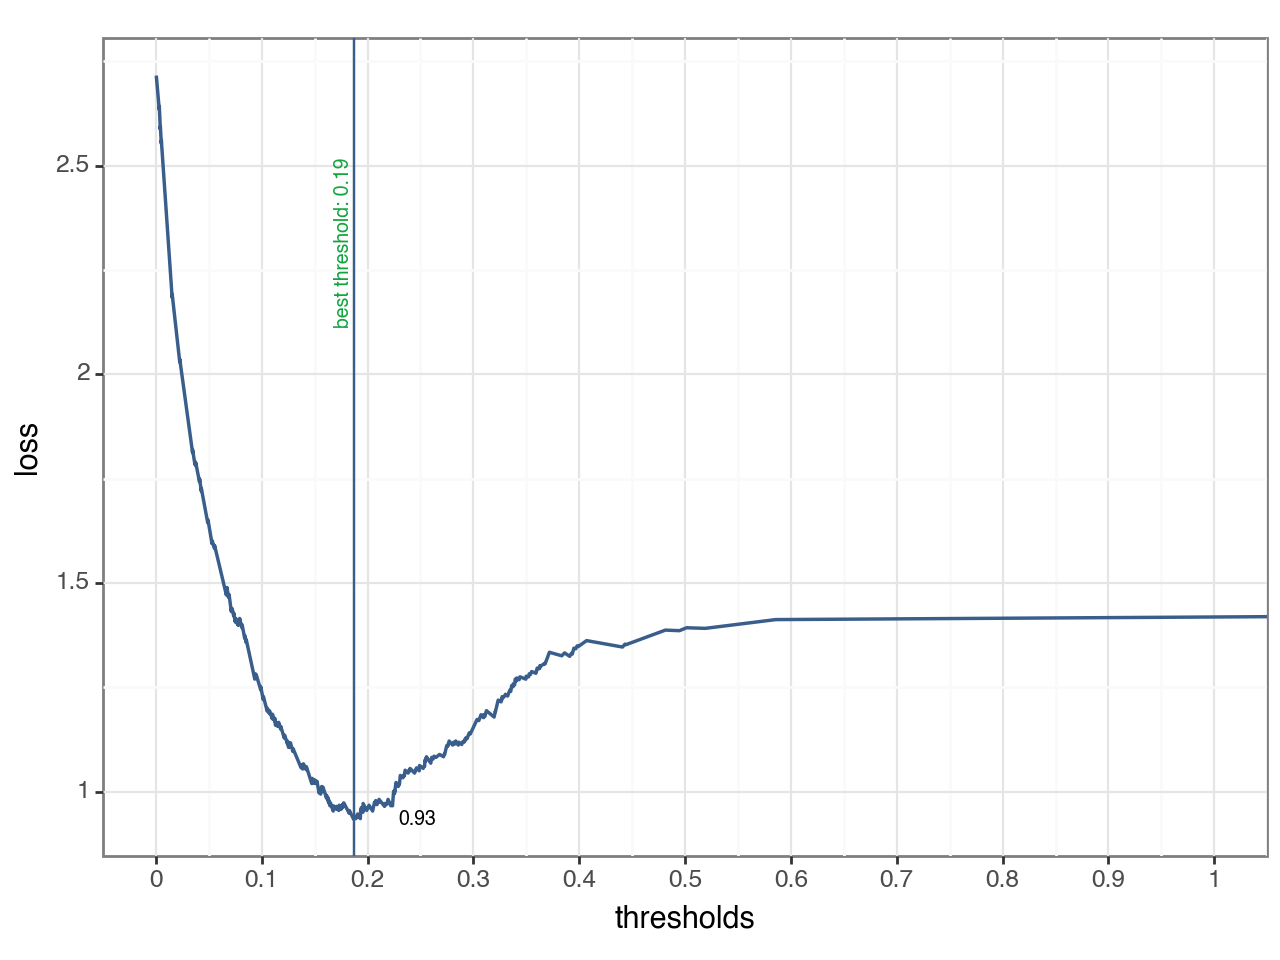

<Figure Size: (640 x 480)>

In [46]:
create_loss_plot(fold5_all_coords['rf'], fold5_threshold['rf'], fold5_expected_loss['rf'])

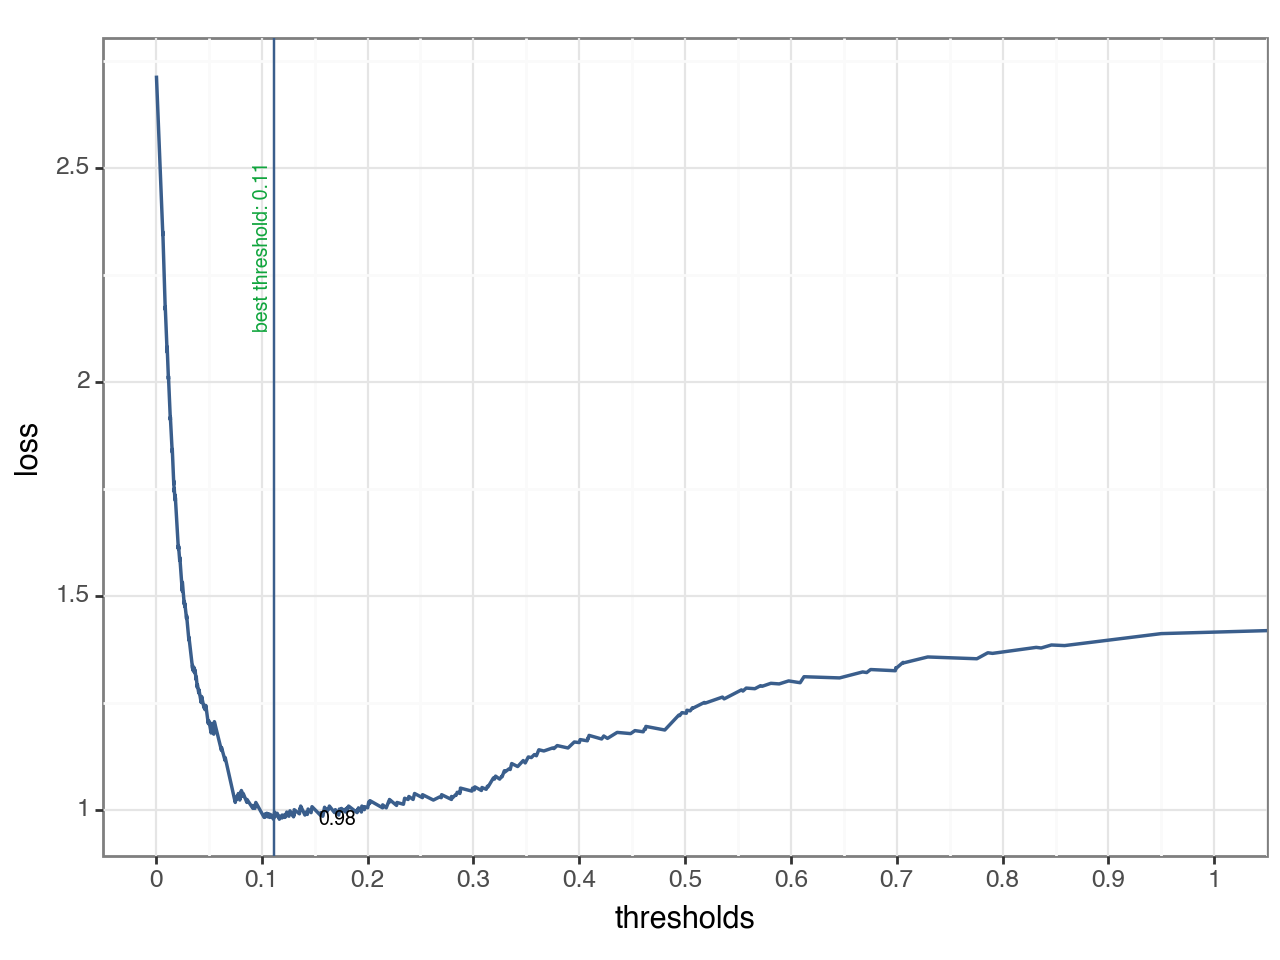

<Figure Size: (640 x 480)>

In [47]:
create_loss_plot(fold5_all_coords['gbm'], fold5_threshold['gbm'], fold5_expected_loss['gbm'])

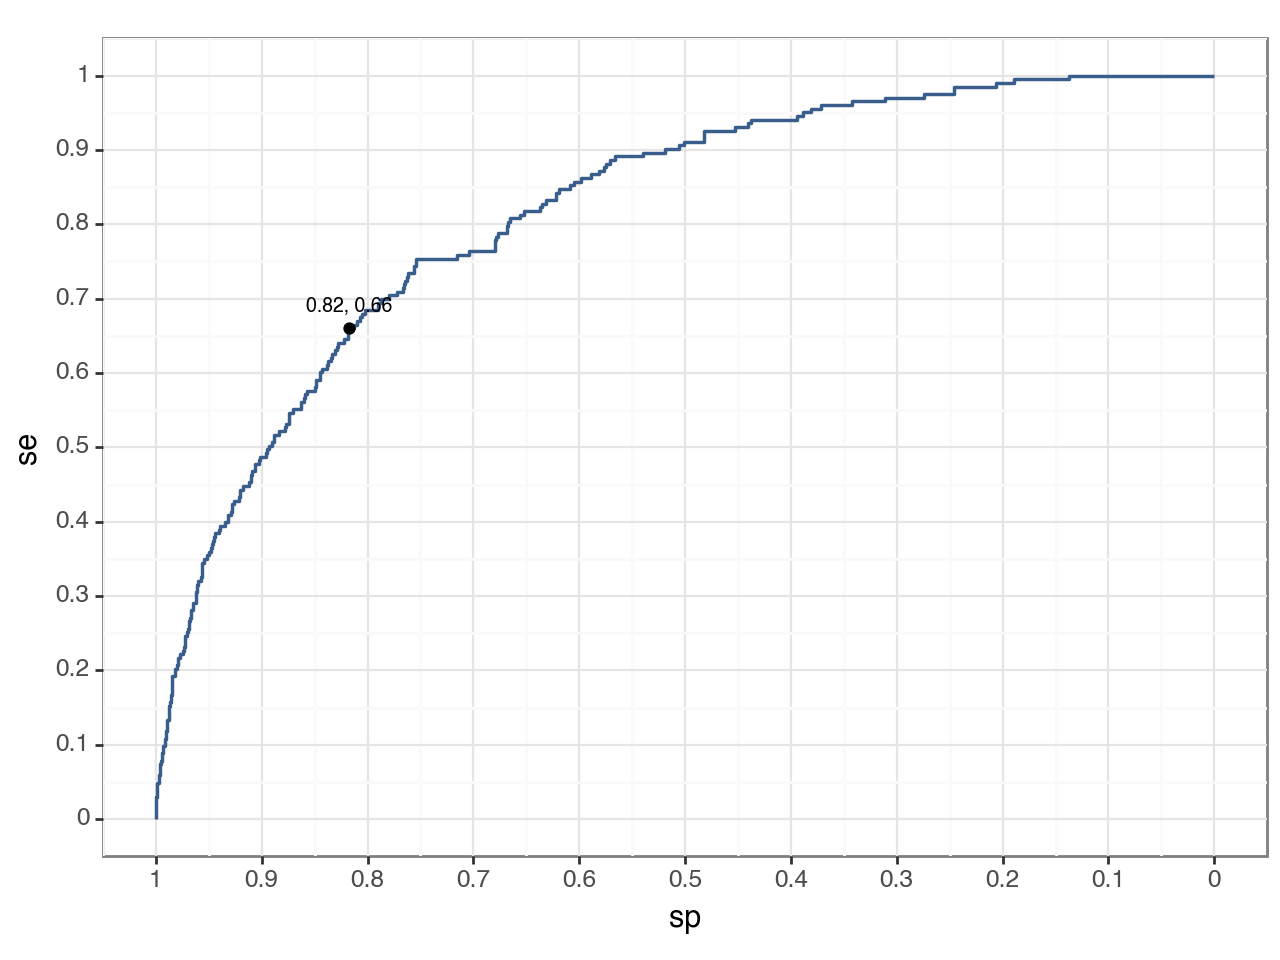

<Figure Size: (640 x 480)>

In [48]:
create_roc_plot_with_optimal(fold5_all_coords['gbm'], fold5_threshold['gbm'])